In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
import scipy as sc
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

import itertools
from itertools import product

import networkx as nx
import pandas as pd
import numpy as np

from pgmpy.models import BayesianModel
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import VariableElimination

from sklearn.metrics import f1_score, accuracy_score, auc, classification_report
import os
sns.set_theme(context="notebook", font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to plot network using matplotlib plt. Size is argument - takes in belief/markov networks
def display(graph, name, size=4):
    pos = nx.circular_layout(graph)
    plt.figure(3,figsize=(5,5)) 
    nx.draw(graph, pos, with_labels=True)
    plt.savefig(name, dpi=300)
    plt.show()

In [3]:
# Takes in belief networks and emits graph skeleton
def graph_skeleton(bn):
    gs = nx.Graph()
    gs.add_nodes_from(bn.nodes())
    gs.add_edges_from(bn.edges())
        
    return gs

In [4]:
# Moralizes graph - connects all unconnected parents of any child
def moralize(bn):
    def get_parents(node):
        return [x[0] for x in bn.in_edges(node)]
    
    nodes = bn.nodes()
    mn = nx.Graph()
    mn.add_nodes_from(nodes)
    
    for node in nodes:
        parents = get_parents(node)
#         print(node, parents)
        
        for par in parents:
            mn.add_edge(node, par)
            
        for par_pair in itertools.combinations(parents, 2):
            if not mn.has_edge(par_pair[0], par_pair[1]):
                mn.add_edge(par_pair[0], par_pair[1])
        
    return mn

In [5]:
# Gets the factor table of variable elimination variable in 2D list format. See below - This is usually printed directly as a string, I wrote a function from the source code to get the values for printing
def get_factortable(df):
    print_state_names = False
    value_index = 0
    factor_table = []
    for prob in product(*[range(card) for card in df.cardinality]):
        if df.state_names and print_state_names:
            prob_list = [
                "{var}({state})".format(
                    var=list(df.variables)[i],
                    state=df.state_names[list(df.variables)[i]][prob[i]],
                )
                for i in range(len(df.variables))
            ]
        else:
            prob_list = [
                prob[i]
#                 f"{list(df.variables)[i]}_{prob[i]}"
                for i in range(len(df.variables))
            ]

        prob_list.append(df.values.ravel()[value_index])
        factor_table.append(prob_list)
        value_index += 1
        
    return factor_table

In [6]:
# Plots factor table with 2 input variables - and 1 output (representing probability) in a 3d plot
def plot_2vars(ft):
    x = [f[0] for f in ft]
    y = [f[1] for f in ft]
    z = [f[2] for f in ft]    
    xs, ys = np.array(x), np.array(y)
    zs = np.array(z)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xs, ys, zs)
    plt.show()

In [7]:
# Plots factor table with 3 input variables - and 1 output (representing probability) in a 3d plot
def plot_3vars(ft):
    x = [f[0] for f in ft]
    y = [f[1] for f in ft]
    z = [f[2] for f in ft]
    c = [f[3] for f in ft]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

### Sample graph 

In [8]:
scaler = StandardScaler()

In [9]:
with open('feat_cols.pkl', 'rb') as f:
    feat_cols = pickle.load(f)

In [10]:
data = pd.read_csv("ld_clean.csv")
status = data['Status']
data = data[feat_cols + ['Status']]
data = data.infer_objects()
data.fillna(data.mean(), inplace=True)
data[feat_cols] = scaler.fit_transform(data[feat_cols])
data = data.iloc[:, :10]
data['Status'] = status
data.head()

,co-applicant_credit_type_EXP,Gender_Joint,total_units_3U,Upfront_charges,Neg_ammortization_neg_amm,construction_type_mh,Secured_by_land,Security_Type_Indriect,occupancy_type_sr,Region_North,Status
0,-0.999233,-0.621238,-0.051483,-0.810002,2.969554,-0.0149,-0.0149,-0.0149,-0.146627,-1.005220,0
1,-0.999233,-0.621238,-0.051483,-0.810002,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,0
2,1.000767,1.609690,-0.051483,-0.993270,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,0
3,1.000767,1.609690,-0.051483,-0.879305,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,0
4,1.000767,1.609690,-0.051483,0.583759,-0.336751,-0.0149,-0.0149,-0.0149,-0.146627,0.994807,0


In [11]:
train_df = data.sample(frac=0.7,random_state=5822)
val_df = data.drop(train_df.index)

In [12]:
corr = train_df.corr()

In [13]:
# plt.figure(figsize=[15,10])
# sns.heatmap(corr)
# plt.show()

In [14]:
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

In [15]:
feat_graph_cols = {}
for ind, i in enumerate(df_lt.columns):
    vals = df_lt[i].reset_index()
    mean = vals[i].mean()
    cols = []
    for col, val in zip(vals['index'], vals[i]):
        if val > mean and col != i:
            cols.append(col)
    feat_graph_cols[i] = cols

In [16]:
feat_graph_cols['Status'] = [x for x in df_lt.columns if x != 'Status' and x != 'co-applicant_credit_type_EXP' and x != 'Neg_ammortization_neg_amm']

In [17]:
feat_graph_cols

{'co-applicant_credit_type_EXP': ['Gender_Joint'],
 'Gender_Joint': ['Region_North'],
 'total_units_3U': [],
 'Upfront_charges': [],
 'Neg_ammortization_neg_amm': [],
 'construction_type_mh': ['Secured_by_land', 'Security_Type_Indriect'],
 'Secured_by_land': ['Security_Type_Indriect'],
 'Security_Type_Indriect': [],
 'occupancy_type_sr': [],
 'Region_North': [],
 'Status': ['Gender_Joint',
  'total_units_3U',
  'Upfront_charges',
  'construction_type_mh',
  'Secured_by_land',
  'Security_Type_Indriect',
  'occupancy_type_sr',
  'Region_North']}

In [18]:
bn_heart = nx.DiGraph()
bn_heart.add_nodes_from(feat_graph_cols.keys())

for k, v in feat_graph_cols.items():
    bn_heart.add_edges_from(([(t, k) for t in v]))

In [19]:
bn_heart_model = BayesianModel(bn_heart.edges())

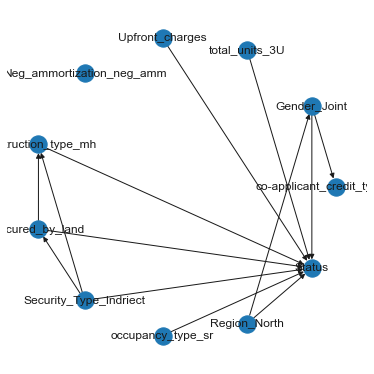

In [20]:
# Displays belief network
display(bn_heart, "BN.png")

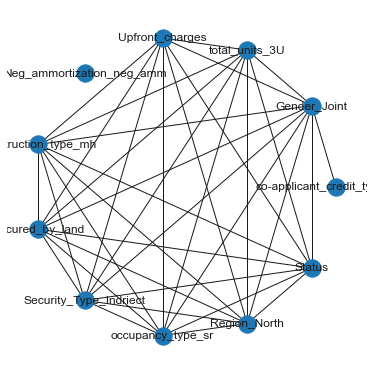

In [21]:
# Displays Markov Network
mn_heart = moralize(bn_heart)
display(mn_heart, name="Moralize.png")

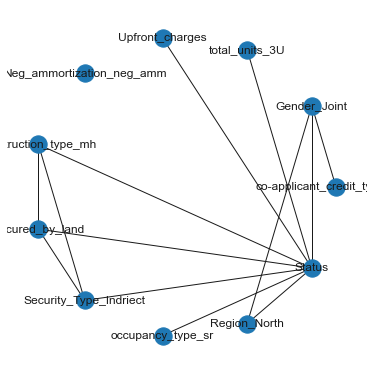

In [22]:
# Displays graph skeleton
bn_heart_skeleton = graph_skeleton(bn_heart)
display(bn_heart_skeleton, name="Skleton.png")

In [23]:
# Fits data into bayesian model
data_sample = train_df.sample(frac=0.01)
print(data_sample.shape)

(1041, 11)


In [24]:
# Fits data into bayesian model
bn_heart_model.fit(data_sample)

In [25]:
# Creates junction tree
jt_heart = BeliefPropagation(bn_heart_model)

In [26]:
jt_heart.calibrate()

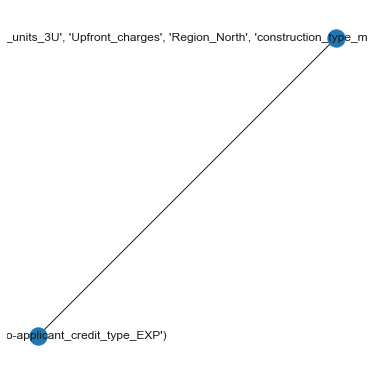

In [27]:
display(jt_heart.junction_tree, name="Jt.png")

In [28]:
# Cliques of JT represented in graph
jt_heart.get_cliques()

NodeView((('Gender_Joint', 'total_units_3U', 'Upfront_charges', 'Region_North', 'construction_type_mh', 'Security_Type_Indriect', 'Status', 'Secured_by_land', 'occupancy_type_sr'), ('Gender_Joint', 'co-applicant_credit_type_EXP')))

In [29]:
inf_heart = VariableElimination(bn_heart_model)

In [30]:
inf_heart.max_marginal(variables=['Status', 'Gender_Joint'])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

0.4379443384775447

In [31]:
# Marginal dist - plotting joint distribution over 3 variables
tc = jt_heart.query(['Upfront_charges', 'Gender_Joint', 'total_units_3U'], evidence={'Status':1})
# print(tc)

In [32]:
tc_ft = get_factortable(tc)

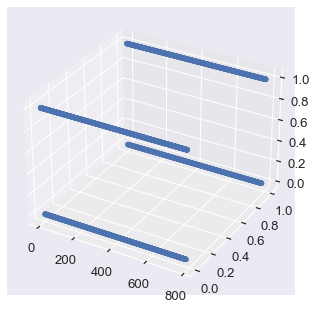

In [33]:
plot_2vars(tc_ft)

In [34]:
# Fitting the model using Maximum Likelihood Estimator

from pgmpy.estimators import MaximumLikelihoodEstimator

mle = MaximumLikelihoodEstimator(model=bn_heart_model, data=data_sample)

# Estimating the CPD for a single node.
print(mle.estimate_cpd(node="Gender_Joint"))

# Estimating CPDs for all the nodes in the model
mle.get_parameters()[:10]  # Show just the first 10 CPDs in the output

+-----------------------------------+-----+----------------------------------+
| Region_North                      | ... | Region_North(0.9948072508051328) |
+-----------------------------------+-----+----------------------------------+
| Gender_Joint(-0.6212377089381499) | ... | 0.6347305389221557               |
+-----------------------------------+-----+----------------------------------+
| Gender_Joint(1.609689794441566)   | ... | 0.3652694610778443               |
+-----------------------------------+-----+----------------------------------+


[<TabularCPD representing P(Gender_Joint:2 | Region_North:2) at 0x7fa8ef8e3190>,
 <TabularCPD representing P(co-applicant_credit_type_EXP:2 | Gender_Joint:2) at 0x7fa8eefaf370>,
 <TabularCPD representing P(Status:2 | Gender_Joint:2, Region_North:2, Secured_by_land:2, Security_Type_Indriect:2, Upfront_charges:784, construction_type_mh:2, occupancy_type_sr:2, total_units_3U:2) at 0x7fa918471760>,
 <TabularCPD representing P(total_units_3U:2) at 0x7fa8ef8e37f0>,
 <TabularCPD representing P(Upfront_charges:784) at 0x7fa8f055b7c0>,
 <TabularCPD representing P(construction_type_mh:2 | Secured_by_land:2, Security_Type_Indriect:2) at 0x7fa8f055bdf0>,
 <TabularCPD representing P(Secured_by_land:2 | Security_Type_Indriect:2) at 0x7fa8eefd8460>,
 <TabularCPD representing P(Security_Type_Indriect:2) at 0x7fa8eeb3f7f0>,
 <TabularCPD representing P(occupancy_type_sr:2) at 0x7fa8eefd8a60>,
 <TabularCPD representing P(Region_North:2) at 0x7fa8ef8ec2e0>]

In [35]:
mle.estimate_cpd(node="Status")

<TabularCPD representing P(Status:2 | Gender_Joint:2, Region_North:2, Secured_by_land:2, Security_Type_Indriect:2, Upfront_charges:784, construction_type_mh:2, occupancy_type_sr:2, total_units_3U:2) at 0x7fa8f07626d0>

In [36]:
# Fitting the using Bayesian Estimator
from pgmpy.estimators import BayesianEstimator

best = BayesianEstimator(model=bn_heart_model, data=data_sample)

print(best.estimate_cpd(node="Status", prior_type="BDeu", equivalent_sample_size=1000))
# Uniform pseudo count for each state. Can also accept an array of the size of CPD.
print(best.estimate_cpd(node="Status", prior_type="dirichlet", pseudo_counts=100))

# Learning CPDs for all the nodes in the model. For learning all parameters with BDeU prior, a dict of
# pseudo_counts need to be provided
best.get_parameters(prior_type="BDeu", equivalent_sample_size=1000)[:10]

+------------------------+-----+
| Gender_Joint           | ... |
+------------------------+-----+
| Region_North           | ... |
+------------------------+-----+
| Secured_by_land        | ... |
+------------------------+-----+
| Security_Type_Indriect | ... |
+------------------------+-----+
| Upfront_charges        | ... |
+------------------------+-----+
| construction_type_mh   | ... |
+------------------------+-----+
| occupancy_type_sr      | ... |
+------------------------+-----+
| total_units_3U         | ... |
+------------------------+-----+
| Status(0)              | ... |
+------------------------+-----+
| Status(1)              | ... |
+------------------------+-----+
+------------------------+-----+
| Gender_Joint           | ... |
+------------------------+-----+
| Region_North           | ... |
+------------------------+-----+
| Secured_by_land        | ... |
+------------------------+-----+
| Security_Type_Indriect | ... |
+------------------------+-----+
| Upfront_

[<TabularCPD representing P(Gender_Joint:2 | Region_North:2) at 0x7fa8eeb03ca0>,
 <TabularCPD representing P(co-applicant_credit_type_EXP:2 | Gender_Joint:2) at 0x7fa8eeb03b20>,
 <TabularCPD representing P(Status:2 | Gender_Joint:2, Region_North:2, Secured_by_land:2, Security_Type_Indriect:2, Upfront_charges:784, construction_type_mh:2, occupancy_type_sr:2, total_units_3U:2) at 0x7fa8f0752be0>,
 <TabularCPD representing P(total_units_3U:2) at 0x7fa8f0558af0>,
 <TabularCPD representing P(Upfront_charges:784) at 0x7fa8f073f640>,
 <TabularCPD representing P(construction_type_mh:2 | Secured_by_land:2, Security_Type_Indriect:2) at 0x7fa8f0752d60>,
 <TabularCPD representing P(Secured_by_land:2 | Security_Type_Indriect:2) at 0x7fa8f0558d60>,
 <TabularCPD representing P(Security_Type_Indriect:2) at 0x7fa8f073f3d0>,
 <TabularCPD representing P(occupancy_type_sr:2) at 0x7fa8f0752fd0>,
 <TabularCPD representing P(Region_North:2) at 0x7fa8f07529d0>]

In [37]:
# Shortcut for learning all the parameters and adding the CPDs to the model.
from pgmpy.models import BayesianNetwork

model_struct = BayesianNetwork(ebunch=bn_heart_model.edges())
model_struct.fit(
    data=data_sample,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=1000,
)

In [38]:
data_sample.columns

Index(['co-applicant_credit_type_EXP', 'Gender_Joint', 'total_units_3U',
       'Upfront_charges', 'Neg_ammortization_neg_amm', 'construction_type_mh',
       'Secured_by_land', 'Security_Type_Indriect', 'occupancy_type_sr',
       'Region_North', 'Status'],
      dtype='object')

In [40]:
model_struct.predict_probability(data_sample)

ValueError: Data has variables which are not in the model